## OCR, Facial Recognition, Computer Vision Project ##

This project is based on an assignment that is part of [Course 5 of 5](https://www.coursera.org/learn/python-project) in the [Python 3 Programming Specialization](https://www.coursera.org/specializations/python-3-programming) on Coursera provided by University of Michigan


#### What does this project do? ####
- Takes a ZIP file of images, extracts the images to a new folder.
- The images contained in the ZIP file are of newspaper pages. Every page contains text, and many of the pages contain images with faces in them.
- Takes any word as input (here we used 'Mark'), and searches each page for occurrences of the word with optical character recognition (OCR).
- If the word we searched for is found on the current page, then the program searches that page for pictures with faces in them. It then returns a contact sheet of thumbnail images with each face contained in the page where the word was found.
- Eg. if you search for 'Bill' it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "Bill".

Note: Due to the size of the images files used, they were included in the .gitignore file in order to upload the project to GitHub. Original project materials can be found [here](https://www.coursera.org/learn/python-project).

In [1]:
import zipfile
import os
import PIL
from PIL import Image, ImageDraw
import pytesseract as tess
import cv2 as cv
import numpy as np
import inspect

tess.pytesseract.tesseract_cmd = r'C:\Users\jgjga\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

In [2]:
# loading the face detection classifier
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')

In [3]:
# Takes a string (file path) as input and returns a grayscale ndarray object
def gry_array_format (img_name): 
    return cv.cvtColor(cv.imread(img_name), cv.COLOR_BGR2GRAY)

In [4]:
#Takes a grayscale numpy array and formats it to a binary array
def bin_array_format(gry_array, thresh):
    return cv.threshold(gry_array, thresh, 255, cv.THRESH_BINARY)[1] 

In [5]:
# Takes a grayscale array and a binary threshold value as input, and returns the text 
# contained in that image as a string
def get_txt(gry_ar_name, t_thresh):
    t_bin_im = bin_array_format(gry_ar_name, t_thresh) #returns a binary array for text recognition
    t_pil_im = Image.fromarray(t_bin_im, "L") # This converts the pixel array into a PIL image
    return ("".join(tess.image_to_string(t_pil_im).lower().split()))


In [6]:
# This function takes a single grayscale array and a binary threshold value as imput
# and it returns the faces contained in that grayscale image as a list of thumbnail face images.
def get_faces(g_array, f_thresh, directory_name):

    f_pil_im = Image.fromarray(g_array, "L") # This converts the pixel array into a PIL image

    if name == "a-0.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.19, 
                                              minNeighbors=10, minSize=(150,150))
    elif name == "a-1.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.19, 
                                              minNeighbors=6, minSize=(35,35))
    elif name == "a-2.png" or name == "a-3.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.16, 
                                              minNeighbors=5, minSize=(85,85))
    elif name == "a-4.png" or name == "a-8.png" or name == "a-10.png" or name == "a-11.png" or name == "a-12.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.55, 
                                              minNeighbors=7, minSize=(100,100))
    elif name == "a-5.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.55, 
                                              minNeighbors=4, minSize=(35,35))
    elif name == "a-6.png" or name == "a-7.png" or name == "a-9.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.12, 
                                              minNeighbors=4, minSize=(90,90))
    elif name == "a-13.png":
        faces = face_cascade.detectMultiScale(g_array, scaleFactor=1.1, 
                                              minNeighbors=6, minSize=(85,85), maxSize = (165, 165))

    with Image.open(f"{directory_name}/{name}") as pil_im:

        cur_pics_lst = [] #List that will be used to hold the thumbnail face images for each picture
        max_size = (100,100)

        for cur_coordinates in faces: # This takes several numpy arrays and turns each one into a 
                                      # thumbnail face image, and appends each one to cur_pics_lst
            coord_tup = (  int(cur_coordinates[0]),  int(cur_coordinates[1]), 
                         (int(cur_coordinates[0]) + int(cur_coordinates[2])), 
                         (int(cur_coordinates[1]) + int(cur_coordinates[3])))
            cropped = (pil_im.crop(coord_tup)) #Cropped is now a pil image of the current "face" instance
            cropped.thumbnail(max_size)
            cur_pics_lst.append(cropped)

    return cur_pics_lst, max_size

In [7]:
# Takes a list of thumbnail face images (from get_faces) and returns a single pil image that is the
# contact sheet from the list of thumbnail face images
def contact_sheet(thumb_lst, mx_size):
    # Figure out how many items are in the lists
    total = len(thumb_lst)

    # Create a new blank PIL image that is the proper width and height to contain the thumbnail images
    if total != 0:
        first_img = thumb_lst[0]
        if total <= 5 :
            #make con_sheet_img 1 row high
            con_sheet_img = PIL.Image.new(first_img.mode, ((mx_size[1] * 5), mx_size[0]))
        elif total <= 10 :
            #make con_sheet_img 2 rows high
            con_sheet_img = PIL.Image.new(first_img.mode, ((mx_size[1] * 5), (mx_size[0] * 2)))
        elif total <= 15 :
            #make con_sheet_img 3 rows high
            con_sheet_img = PIL.Image.new(first_img.mode, ((mx_size[1] * 5), (mx_size[0] * 3)))

    # Paste each thumbnail face image onto the blank contact sheet image
    cur_x_location = 0
    cur_y_location = 0
    counter = 0
    for face_thumb in thumb_lst:
        if counter == 0 :
            cur_x_location = 0
            cur_y_location = 0
        elif counter <= 4 :
            cur_x_location = (cur_x_location + mx_size[0])
        elif counter == 5 :
            cur_x_location = 0
            cur_y_location = (cur_y_location + mx_size[1])
        elif counter <= 9 :
            cur_x_location = (cur_x_location + mx_size[0])
        elif counter == 10 :
            cur_x_location = 0
            cur_y_location = (cur_y_location + mx_size[1])
        elif counter <= 14 :
            cur_x_location = (cur_x_location + mx_size[0])

        con_sheet_img.paste(face_thumb, (cur_x_location, cur_y_location))
        counter += 1
    if total != 0:
        return con_sheet_img

In [8]:
#Zipped file handling
target_file = 'images/images.zip'
file = 'images/unpacked_large_images'
img_file = zipfile.ZipFile(target_file)
# Extracts all the images from the original zip file to 'unpacked_large_images'
img_file.extractall(file) 
img_file.close()

In [9]:
t_val = 240 # Binary threshold value for text recognition
f_val = 165 # Binary threshold value for facial recognition
master_dict = {}
#search_term = input()
search_term = "Mark"
search_term = search_term.lower()

Currently searching for "mark" in the file: images/unpacked_large_images

Searching for results in image a-0.png
Found results in image a-0.png


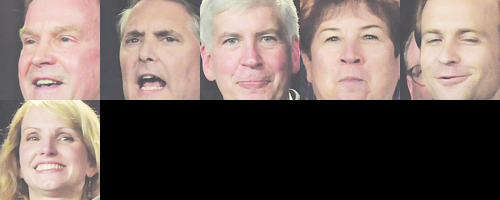


Searching for results in image a-1.png
Found results in image a-1.png


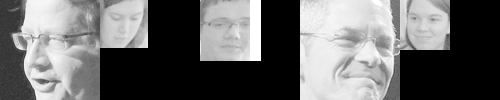


Searching for results in image a-10.png
Found results in image a-10.png
But there were no faces in that file!

Searching for results in image a-11.png
Found no results in image a-11.png

Searching for results in image a-12.png
Found no results in image a-12.png

Searching for results in image a-13.png
Found results in image a-13.png


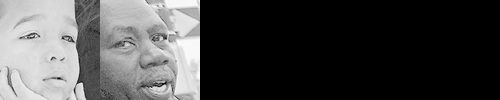


Searching for results in image a-2.png
Found results in image a-2.png


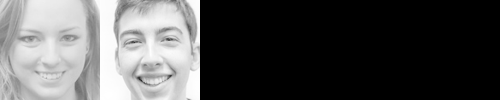


Searching for results in image a-3.png
Found results in image a-3.png


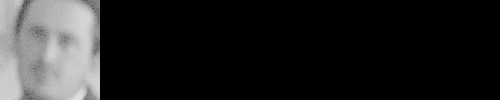


Searching for results in image a-4.png
Found no results in image a-4.png

Searching for results in image a-5.png
Found results in image a-5.png


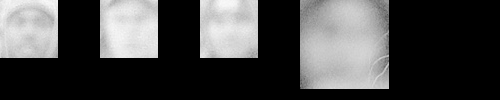


Searching for results in image a-6.png
Found no results in image a-6.png

Searching for results in image a-7.png
Found no results in image a-7.png

Searching for results in image a-8.png
Found results in image a-8.png
But there were no faces in that file!

Searching for results in image a-9.png
Found no results in image a-9.png


In [10]:
# Generate a list of file names within the target file
current_im_lst = [pic_name for pic_name in os.listdir(file)]

print(f'Currently searching for "{search_term}" in the file: {file}')

for name in current_im_lst:
    # Convert to grayscale - This returns a grayscale array from an image
    gry_pic = gry_array_format("{}/{}".format(file, name))

    # Get the text from the current image -This returns a string that is the 
    # text contained in an image
    cur_text = get_txt(gry_pic, t_val)

    # Get the contact sheet from the current image - This returns the list of thumbnail 
    # face images that occur within the image it receives
    cur_pics = get_faces(gry_pic, f_val, file)

    # Takes a list of images and a thumbnail size tuple as input and 
    # returns the contact sheet as a pil image
    cur_contact_sheet = contact_sheet(cur_pics[0], cur_pics[1])

    # Creates an entry into master_dict with the original image name as the key, and a list
    # containing the ocr text string and the contact sheet as the value
    master_dict[name] = [cur_text, cur_contact_sheet]

    print(f"\nSearching for results in image {name}")
    
    # Check to see if the search term is found in the current image
    
    if search_term in master_dict[name][0]:
        print(f"Found results in image {name}")
        
        # Display thumbnails of the faces found in the current image
        if master_dict[name][1] != None :
            display(master_dict[name][1])
        else:
            print("But there were no faces in that file!")
    else:
        print(f'Found no results in image {name}')
